#### This notebook trains our baseline model

Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, default_collate
from torchvision import datasets, transforms
from torchvision.transforms.v2 import MixUp, CutMix
os.chdir("../models")
from model import CustomCNN
from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform, CustomRegularizeTransform

import matplotlib.pyplot as plt

# set seed
set_seed(42)

Initialise model and dataset

In [2]:
model = CustomCNN(fcn_depth=3, fcn_width=[1024, 512]) # initialise model

transform1 = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((100, 100), antialias=True),
    transforms.ColorJitter(brightness=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(0.5),
    # most of the pictures are rotation invariant
    # moreover, rotation transformation increases the epoch time by more than ~1 minute
    # transforms.RandomRotation((-30, 30)),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), antialias=True),
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100), antialias=True),
])

# default pytorch value alpha = 1 is suboptimal for this
# alpha = 0.4 -> accuracy ~ 0.6
# alpha = 0.2 -> accuray ~ 0.67 (!!!)
alpha = 0.2

def mixup_collate_fn(batch):
    return MixUp(num_classes=102, alpha=alpha)(*default_collate(batch))

# load data
train_dataset = datasets.Flowers102(root='../data', split='test', download=True, transform=transform1) 
val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=transform2) 
test_dataset = datasets.Flowers102(root='../data', split='train', download=True, transform=transform2)
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped

# Uncomment below if you have some CUDA memory allocation errors
# Also try to experiment with the value to maximize GPU usage
# os.environ['PYTORCH_CUDA_ALLOC_CONF']='max_split_size_mb:256'

batch_size = 128
# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=mixup_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Visualize the original images and their transformed version

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


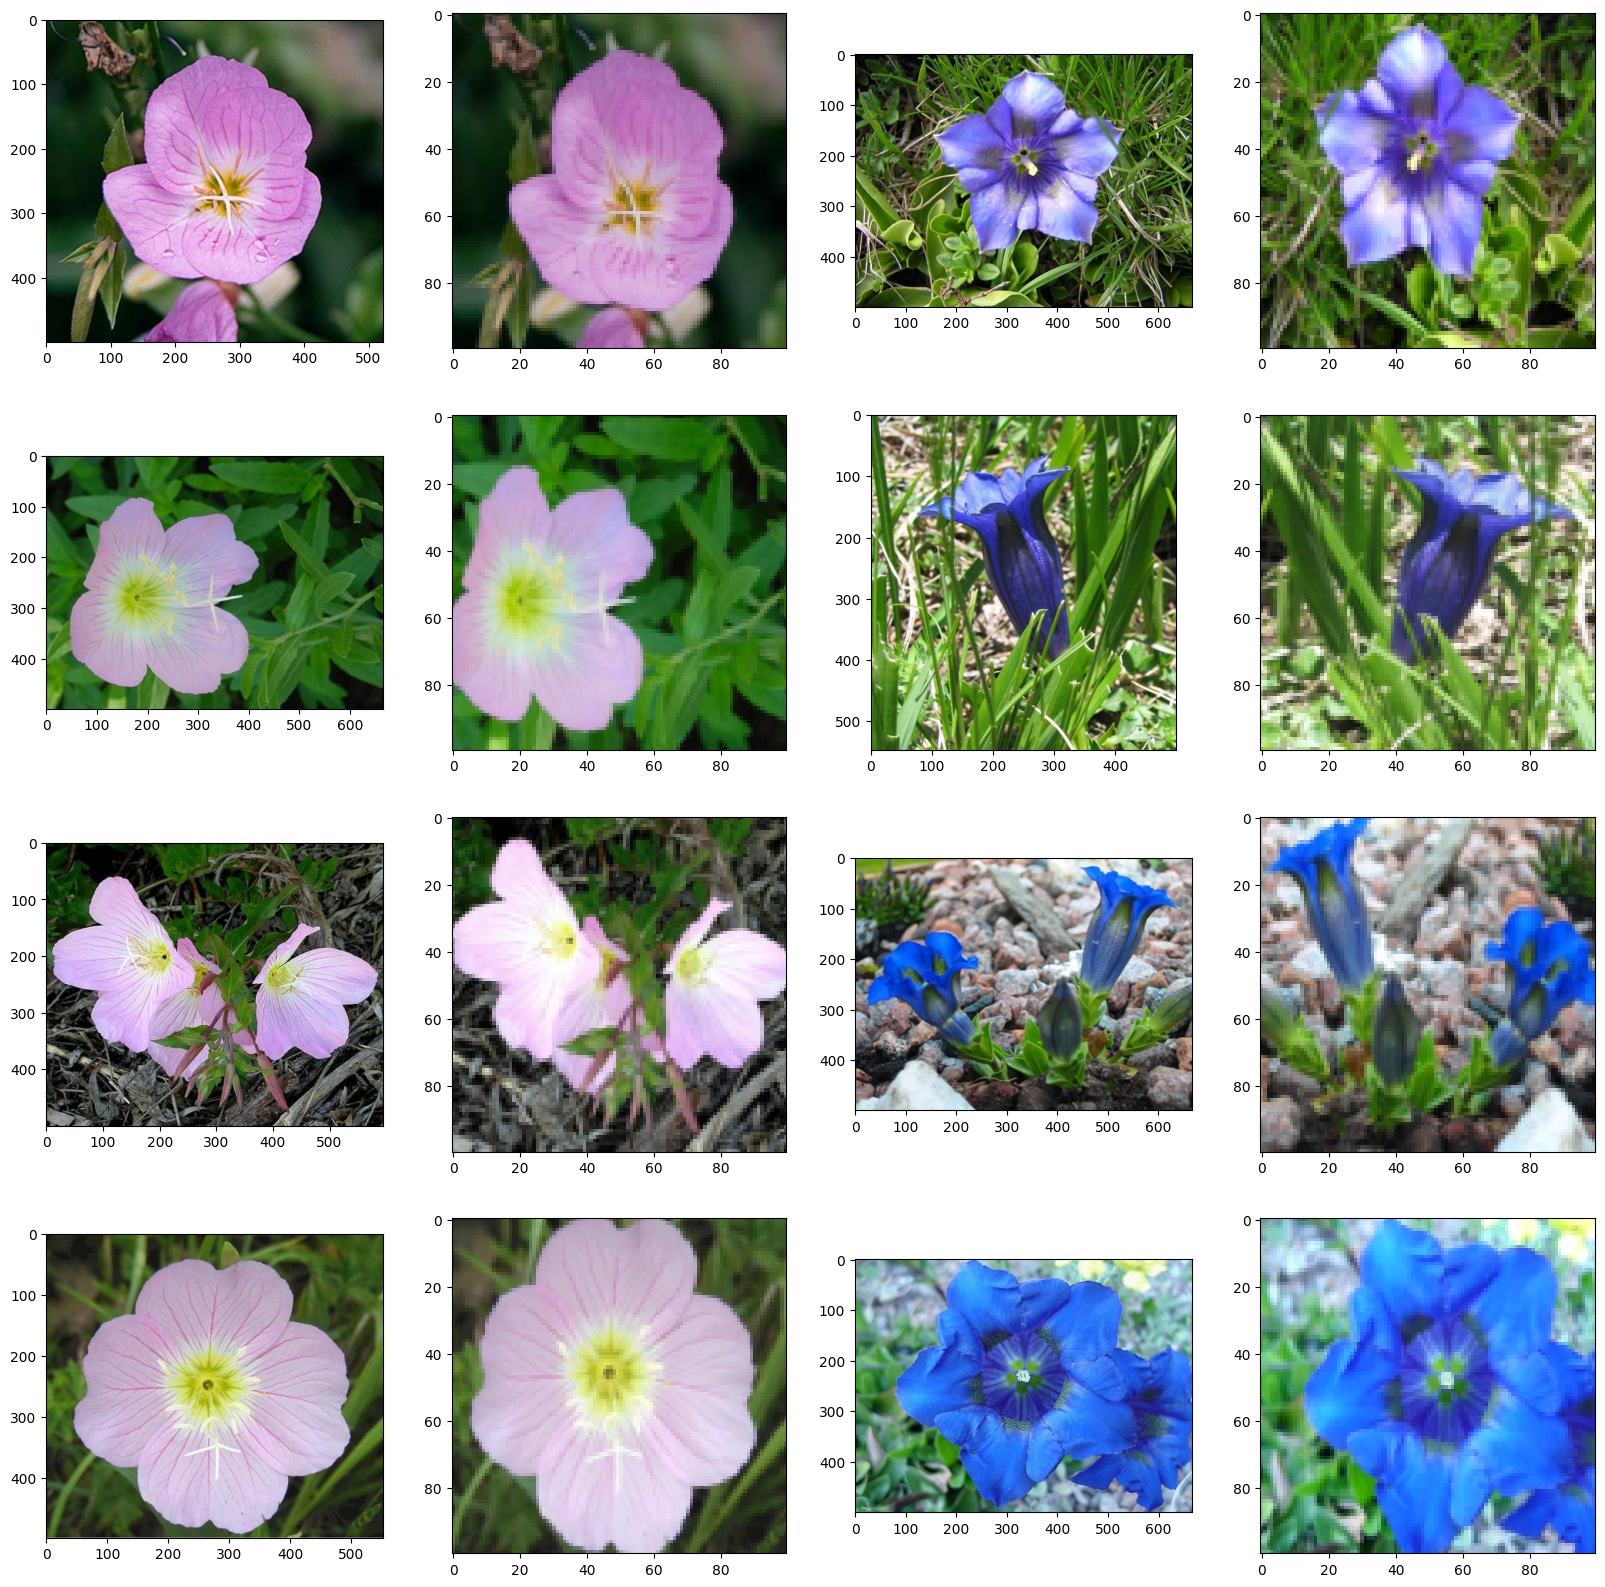

In [3]:
from itertools import product

train_dataset_ = datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor()) 

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
offset = 1000 # Change this to get different images

for i, j in product(range(4), range(2)):
    axs[i][2*j].imshow(train_dataset_[i+j*offset][0].permute(1, 2, 0))
    axs[i][2*j+1].imshow(train_dataset[i+j*offset][0].permute(1, 2, 0))

Visualize MixUp/Cutup. For alpha = 1, the mix-up is visible. For alpha <= 0.4, it is hard to notice the mix-up by eye.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


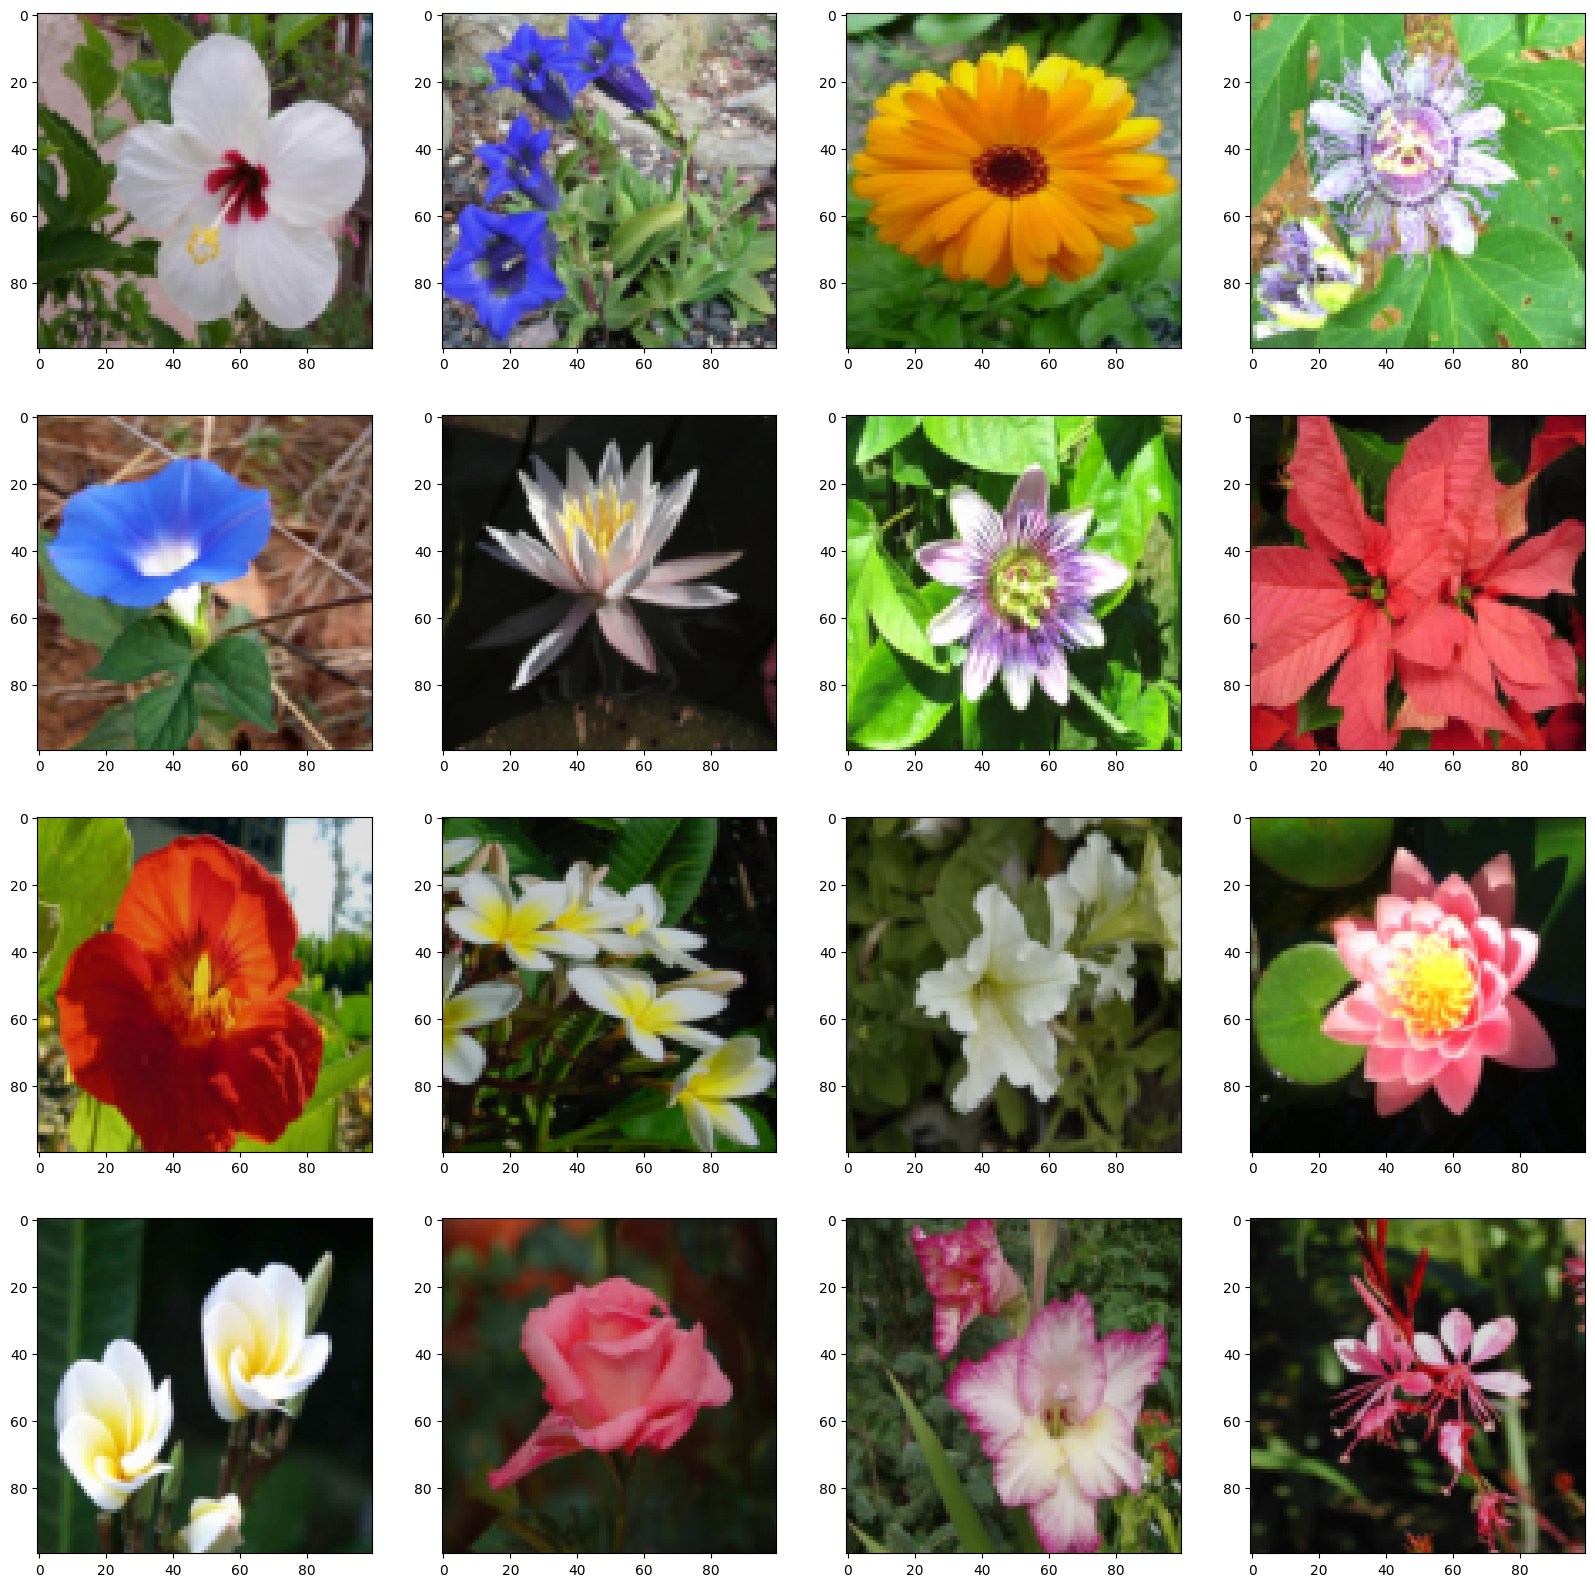

In [4]:
train_dataloader_ = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=mixup_collate_fn)

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for imgs, labs in train_dataloader_:
    for i, j in product(range(4), range(4)):
        axs[i][j].imshow(imgs[4*i+j].permute(1, 2, 0))
    break

Specify hyperparameters

In [5]:
lr = 0.0001 # learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=lr) # initialise optimiser
loss = torch.nn.CrossEntropyLoss() # initialise loss function

if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)

epochs = 300 # number of epochs
early_stopper = EarlyStopper(patience=100) # initialise early stopper


# Make directory to save baseline model
baseline_model_path = "./saved_models/baseline_model/non_preprocessed"
if not os.path.exists(baseline_model_path):
    os.makedirs(baseline_model_path, exist_ok=True)

# Define the device-specific path
device_type = None
if device == torch.device("cuda"):
    device_type = "cuda"
elif device == torch.device("mps"):
    device_type = "mps"
else:
    device_type = "cpu"

# Construct the full path
device_path = os.path.join(baseline_model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

model

CustomCNN(
  (conv_stack): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (1): DeformConv2d(
      (conv_offset): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (dcn_conv): DeformConv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (2): ReLU()
    (3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
    (7): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (8): ReLU()
    (9): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (12): Conv2d(12

Train the model

In [6]:
train_loss_list, val_loss_list, val_acc_list = train(model, train_dataloader, val_dataloader, optimiser, loss, device, epochs, early_stopper, device_path) # train model

Epoch 1/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=4.3783]


Epoch 1/300 took 63.01s | Train loss: 4.3783 | Val loss: 4.6887 | Val accuracy: 1.18% | EarlyStopper count: 0


Epoch 2/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=3.9269]


Epoch 2/300 took 60.54s | Train loss: 3.9269 | Val loss: 4.0400 | Val accuracy: 10.20% | EarlyStopper count: 0


Epoch 3/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=3.7023]


Epoch 3/300 took 59.38s | Train loss: 3.7023 | Val loss: 3.5612 | Val accuracy: 18.82% | EarlyStopper count: 0


Epoch 4/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=3.4395]


Epoch 4/300 took 60.03s | Train loss: 3.4395 | Val loss: 3.3832 | Val accuracy: 21.27% | EarlyStopper count: 0


Epoch 5/300: 100%|██████████| 49/49 [00:58<00:00,  1.20s/it, Training loss=3.3048]


Epoch 5/300 took 63.17s | Train loss: 3.3048 | Val loss: 3.2337 | Val accuracy: 24.22% | EarlyStopper count: 0


Epoch 6/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=3.1489]


Epoch 6/300 took 61.46s | Train loss: 3.1489 | Val loss: 3.1184 | Val accuracy: 26.08% | EarlyStopper count: 0


Epoch 7/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=3.0535]


Epoch 7/300 took 61.14s | Train loss: 3.0535 | Val loss: 2.9963 | Val accuracy: 29.22% | EarlyStopper count: 0


Epoch 8/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=2.9773]


Epoch 8/300 took 61.12s | Train loss: 2.9773 | Val loss: 2.9046 | Val accuracy: 30.88% | EarlyStopper count: 0


Epoch 9/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=2.7884]


Epoch 9/300 took 60.05s | Train loss: 2.7884 | Val loss: 2.8012 | Val accuracy: 33.33% | EarlyStopper count: 0


Epoch 10/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=2.8111]


Epoch 10/300 took 60.39s | Train loss: 2.8111 | Val loss: 2.7466 | Val accuracy: 34.71% | EarlyStopper count: 0


Epoch 11/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=2.6710]


Epoch 11/300 took 60.84s | Train loss: 2.6710 | Val loss: 2.6979 | Val accuracy: 34.61% | EarlyStopper count: 0


Epoch 12/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=2.5462]


Epoch 12/300 took 59.98s | Train loss: 2.5462 | Val loss: 2.6390 | Val accuracy: 36.76% | EarlyStopper count: 0


Epoch 13/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=2.6533]


Epoch 13/300 took 59.74s | Train loss: 2.6533 | Val loss: 2.5529 | Val accuracy: 37.06% | EarlyStopper count: 0


Epoch 14/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=2.4754]


Epoch 14/300 took 59.62s | Train loss: 2.4754 | Val loss: 2.5508 | Val accuracy: 37.75% | EarlyStopper count: 0


Epoch 15/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=2.6441]


Epoch 15/300 took 61.17s | Train loss: 2.6441 | Val loss: 2.5207 | Val accuracy: 37.25% | EarlyStopper count: 0


Epoch 16/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=2.4894]


Epoch 16/300 took 60.15s | Train loss: 2.4894 | Val loss: 2.4471 | Val accuracy: 39.12% | EarlyStopper count: 0


Epoch 19/300: 100%|██████████| 49/49 [00:57<00:00,  1.16s/it, Training loss=2.3062]


Epoch 19/300 took 61.05s | Train loss: 2.3062 | Val loss: 2.2741 | Val accuracy: 41.76% | EarlyStopper count: 0


Epoch 20/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=2.1830]


Epoch 20/300 took 59.86s | Train loss: 2.1830 | Val loss: 2.2330 | Val accuracy: 43.24% | EarlyStopper count: 0


Epoch 21/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=2.2653]


Epoch 21/300 took 60.26s | Train loss: 2.2653 | Val loss: 2.2339 | Val accuracy: 43.43% | EarlyStopper count: 0


Epoch 22/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=2.1569]


Epoch 22/300 took 59.82s | Train loss: 2.1569 | Val loss: 2.1948 | Val accuracy: 44.51% | EarlyStopper count: 1


Epoch 23/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=2.2653]


Epoch 23/300 took 60.31s | Train loss: 2.2653 | Val loss: 2.1601 | Val accuracy: 45.20% | EarlyStopper count: 0


Epoch 24/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=2.2766]


Epoch 24/300 took 60.66s | Train loss: 2.2766 | Val loss: 2.1357 | Val accuracy: 45.98% | EarlyStopper count: 0


Epoch 25/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=2.2413]


Epoch 25/300 took 61.52s | Train loss: 2.2413 | Val loss: 2.1592 | Val accuracy: 45.20% | EarlyStopper count: 0


Epoch 26/300: 100%|██████████| 49/49 [01:00<00:00,  1.24s/it, Training loss=2.3692]


Epoch 26/300 took 64.88s | Train loss: 2.3692 | Val loss: 2.1244 | Val accuracy: 45.20% | EarlyStopper count: 1


Epoch 27/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=2.4215]


Epoch 27/300 took 60.02s | Train loss: 2.4215 | Val loss: 2.1136 | Val accuracy: 45.39% | EarlyStopper count: 0


Epoch 28/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=2.3107]


Epoch 28/300 took 61.59s | Train loss: 2.3107 | Val loss: 2.0527 | Val accuracy: 48.73% | EarlyStopper count: 0


Epoch 29/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=2.2205]


Epoch 29/300 took 61.35s | Train loss: 2.2205 | Val loss: 2.0461 | Val accuracy: 49.61% | EarlyStopper count: 0


Epoch 30/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=2.1476]


Epoch 30/300 took 60.39s | Train loss: 2.1476 | Val loss: 1.9943 | Val accuracy: 50.39% | EarlyStopper count: 0


Epoch 31/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=2.1110]


Epoch 31/300 took 62.30s | Train loss: 2.1110 | Val loss: 1.9495 | Val accuracy: 50.78% | EarlyStopper count: 0


Epoch 32/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=2.1551]


Epoch 32/300 took 61.68s | Train loss: 2.1551 | Val loss: 1.9281 | Val accuracy: 51.76% | EarlyStopper count: 0


Epoch 33/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=2.0678]


Epoch 33/300 took 60.09s | Train loss: 2.0678 | Val loss: 1.9262 | Val accuracy: 51.76% | EarlyStopper count: 0


Epoch 34/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.9478]


Epoch 34/300 took 59.84s | Train loss: 1.9478 | Val loss: 1.9124 | Val accuracy: 51.47% | EarlyStopper count: 0


Epoch 35/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.9538]


Epoch 35/300 took 59.87s | Train loss: 1.9538 | Val loss: 1.8524 | Val accuracy: 53.33% | EarlyStopper count: 0


Epoch 36/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.8291]


Epoch 36/300 took 60.76s | Train loss: 1.8291 | Val loss: 1.8476 | Val accuracy: 53.24% | EarlyStopper count: 0


Epoch 37/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=2.0873]


Epoch 37/300 took 60.24s | Train loss: 2.0873 | Val loss: 1.8319 | Val accuracy: 54.12% | EarlyStopper count: 0


Epoch 38/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=2.1288]


Epoch 38/300 took 63.02s | Train loss: 2.1288 | Val loss: 1.8042 | Val accuracy: 54.61% | EarlyStopper count: 0


Epoch 39/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.9461]


Epoch 39/300 took 59.97s | Train loss: 1.9461 | Val loss: 1.7700 | Val accuracy: 55.10% | EarlyStopper count: 0


Epoch 40/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.9279]


Epoch 40/300 took 60.23s | Train loss: 1.9279 | Val loss: 1.7790 | Val accuracy: 54.51% | EarlyStopper count: 0


Epoch 41/300: 100%|██████████| 49/49 [00:57<00:00,  1.16s/it, Training loss=2.1193]


Epoch 41/300 took 61.33s | Train loss: 2.1193 | Val loss: 1.7975 | Val accuracy: 53.24% | EarlyStopper count: 1


Epoch 42/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=1.8427]


Epoch 42/300 took 60.40s | Train loss: 1.8427 | Val loss: 1.7501 | Val accuracy: 55.00% | EarlyStopper count: 2


Epoch 43/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.9991]


Epoch 43/300 took 59.43s | Train loss: 1.9991 | Val loss: 1.7313 | Val accuracy: 56.37% | EarlyStopper count: 0


Epoch 44/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.8455]


Epoch 44/300 took 59.71s | Train loss: 1.8455 | Val loss: 1.7340 | Val accuracy: 54.90% | EarlyStopper count: 0


Epoch 45/300: 100%|██████████| 49/49 [00:58<00:00,  1.20s/it, Training loss=1.8100]


Epoch 45/300 took 63.12s | Train loss: 1.8100 | Val loss: 1.6866 | Val accuracy: 56.18% | EarlyStopper count: 1


Epoch 46/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=1.8090]


Epoch 46/300 took 63.25s | Train loss: 1.8090 | Val loss: 1.6564 | Val accuracy: 57.25% | EarlyStopper count: 0


Epoch 47/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.5959]


Epoch 47/300 took 59.14s | Train loss: 1.5959 | Val loss: 1.6461 | Val accuracy: 56.76% | EarlyStopper count: 0


Epoch 48/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.8053]


Epoch 48/300 took 61.12s | Train loss: 1.8053 | Val loss: 1.6228 | Val accuracy: 58.92% | EarlyStopper count: 0


Epoch 49/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.5087]


Epoch 49/300 took 62.22s | Train loss: 1.5087 | Val loss: 1.6269 | Val accuracy: 57.65% | EarlyStopper count: 0


Epoch 50/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.7711]


Epoch 50/300 took 61.26s | Train loss: 1.7711 | Val loss: 1.6244 | Val accuracy: 56.57% | EarlyStopper count: 1


Epoch 51/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.9266]


Epoch 51/300 took 59.72s | Train loss: 1.9266 | Val loss: 1.5904 | Val accuracy: 57.75% | EarlyStopper count: 2


Epoch 52/300: 100%|██████████| 49/49 [00:58<00:00,  1.18s/it, Training loss=1.5854]


Epoch 52/300 took 62.19s | Train loss: 1.5854 | Val loss: 1.5878 | Val accuracy: 59.02% | EarlyStopper count: 0


Epoch 53/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.7709]


Epoch 53/300 took 60.32s | Train loss: 1.7709 | Val loss: 1.5847 | Val accuracy: 58.63% | EarlyStopper count: 0


Epoch 54/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.9977]


Epoch 54/300 took 60.74s | Train loss: 1.9977 | Val loss: 1.5651 | Val accuracy: 60.39% | EarlyStopper count: 0


Epoch 55/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.6840]


Epoch 55/300 took 59.91s | Train loss: 1.6840 | Val loss: 1.5635 | Val accuracy: 59.61% | EarlyStopper count: 0


Epoch 56/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.8097]


Epoch 56/300 took 60.70s | Train loss: 1.8097 | Val loss: 1.5793 | Val accuracy: 58.14% | EarlyStopper count: 0


Epoch 57/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.7097]


Epoch 57/300 took 59.86s | Train loss: 1.7097 | Val loss: 1.5606 | Val accuracy: 59.71% | EarlyStopper count: 1


Epoch 58/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.7996]


Epoch 58/300 took 59.76s | Train loss: 1.7996 | Val loss: 1.5316 | Val accuracy: 60.10% | EarlyStopper count: 0


Epoch 59/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.8187]


Epoch 59/300 took 61.77s | Train loss: 1.8187 | Val loss: 1.5389 | Val accuracy: 60.20% | EarlyStopper count: 0


Epoch 60/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.7337]


Epoch 60/300 took 60.86s | Train loss: 1.7337 | Val loss: 1.5956 | Val accuracy: 58.82% | EarlyStopper count: 1


Epoch 61/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.7400]


Epoch 61/300 took 60.66s | Train loss: 1.7400 | Val loss: 1.5531 | Val accuracy: 58.43% | EarlyStopper count: 2


Epoch 62/300: 100%|██████████| 49/49 [01:00<00:00,  1.23s/it, Training loss=1.6255]


Epoch 62/300 took 64.21s | Train loss: 1.6255 | Val loss: 1.5475 | Val accuracy: 59.31% | EarlyStopper count: 3


Epoch 63/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.7636]


Epoch 63/300 took 60.15s | Train loss: 1.7636 | Val loss: 1.5180 | Val accuracy: 59.90% | EarlyStopper count: 4


Epoch 64/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.6030]


Epoch 64/300 took 60.32s | Train loss: 1.6030 | Val loss: 1.5293 | Val accuracy: 60.10% | EarlyStopper count: 0


Epoch 65/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5746]


Epoch 65/300 took 59.79s | Train loss: 1.5746 | Val loss: 1.5001 | Val accuracy: 61.47% | EarlyStopper count: 1


Epoch 66/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.5755]


Epoch 66/300 took 60.51s | Train loss: 1.5755 | Val loss: 1.4928 | Val accuracy: 61.47% | EarlyStopper count: 0


Epoch 67/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.6751]


Epoch 67/300 took 60.50s | Train loss: 1.6751 | Val loss: 1.4816 | Val accuracy: 61.96% | EarlyStopper count: 0


Epoch 68/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.4676]


Epoch 68/300 took 60.76s | Train loss: 1.4676 | Val loss: 1.4757 | Val accuracy: 61.57% | EarlyStopper count: 0


Epoch 69/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.9378]


Epoch 69/300 took 59.35s | Train loss: 1.9378 | Val loss: 1.7683 | Val accuracy: 54.02% | EarlyStopper count: 0


Epoch 70/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=2.1079]


Epoch 70/300 took 60.39s | Train loss: 2.1079 | Val loss: 1.6984 | Val accuracy: 55.49% | EarlyStopper count: 1


Epoch 71/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.9684]


Epoch 71/300 took 60.61s | Train loss: 1.9684 | Val loss: 1.7174 | Val accuracy: 55.29% | EarlyStopper count: 2


Epoch 72/300: 100%|██████████| 49/49 [00:54<00:00,  1.12s/it, Training loss=1.8204]


Epoch 72/300 took 58.94s | Train loss: 1.8204 | Val loss: 1.6441 | Val accuracy: 56.47% | EarlyStopper count: 3


Epoch 73/300: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it, Training loss=1.8130]


Epoch 73/300 took 62.61s | Train loss: 1.8130 | Val loss: 1.6337 | Val accuracy: 57.84% | EarlyStopper count: 4


Epoch 74/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=1.8740]


Epoch 74/300 took 63.26s | Train loss: 1.8740 | Val loss: 1.6528 | Val accuracy: 56.67% | EarlyStopper count: 5


Epoch 75/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.9364]


Epoch 75/300 took 59.44s | Train loss: 1.9364 | Val loss: 1.6083 | Val accuracy: 57.75% | EarlyStopper count: 6


Epoch 76/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=2.0043]


Epoch 76/300 took 60.36s | Train loss: 2.0043 | Val loss: 1.6079 | Val accuracy: 58.14% | EarlyStopper count: 7


Epoch 77/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.7430]


Epoch 77/300 took 59.22s | Train loss: 1.7430 | Val loss: 1.6099 | Val accuracy: 58.53% | EarlyStopper count: 8


Epoch 78/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.9115]


Epoch 78/300 took 59.45s | Train loss: 1.9115 | Val loss: 1.5853 | Val accuracy: 57.25% | EarlyStopper count: 9


Epoch 79/300: 100%|██████████| 49/49 [01:00<00:00,  1.23s/it, Training loss=1.7088]


Epoch 79/300 took 64.69s | Train loss: 1.7088 | Val loss: 1.5565 | Val accuracy: 58.92% | EarlyStopper count: 10


Epoch 80/300: 100%|██████████| 49/49 [00:58<00:00,  1.20s/it, Training loss=1.5484]


Epoch 80/300 took 62.83s | Train loss: 1.5484 | Val loss: 1.5532 | Val accuracy: 59.12% | EarlyStopper count: 11


Epoch 81/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=2.0028]


Epoch 81/300 took 60.78s | Train loss: 2.0028 | Val loss: 1.5289 | Val accuracy: 60.20% | EarlyStopper count: 12


Epoch 82/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.4987]


Epoch 82/300 took 59.77s | Train loss: 1.4987 | Val loss: 1.5351 | Val accuracy: 60.59% | EarlyStopper count: 13


Epoch 83/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.6791]


Epoch 83/300 took 60.34s | Train loss: 1.6791 | Val loss: 1.5743 | Val accuracy: 58.92% | EarlyStopper count: 14


Epoch 84/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.6171]


Epoch 84/300 took 59.66s | Train loss: 1.6171 | Val loss: 1.5438 | Val accuracy: 59.71% | EarlyStopper count: 15


Epoch 85/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.5554]


Epoch 85/300 took 60.62s | Train loss: 1.5554 | Val loss: 1.5467 | Val accuracy: 58.63% | EarlyStopper count: 16


Epoch 86/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.7609]


Epoch 86/300 took 60.42s | Train loss: 1.7609 | Val loss: 1.5244 | Val accuracy: 59.31% | EarlyStopper count: 17


Epoch 87/300: 100%|██████████| 49/49 [00:59<00:00,  1.22s/it, Training loss=1.7451]


Epoch 87/300 took 63.92s | Train loss: 1.7451 | Val loss: 1.5219 | Val accuracy: 59.71% | EarlyStopper count: 18


Epoch 88/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.7540]


Epoch 88/300 took 60.06s | Train loss: 1.7540 | Val loss: 1.5263 | Val accuracy: 59.51% | EarlyStopper count: 19


Epoch 89/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.5371]


Epoch 89/300 took 61.01s | Train loss: 1.5371 | Val loss: 1.5121 | Val accuracy: 59.61% | EarlyStopper count: 20


Epoch 90/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.4385]


Epoch 90/300 took 60.70s | Train loss: 1.4385 | Val loss: 1.4721 | Val accuracy: 60.98% | EarlyStopper count: 21


Epoch 91/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.7160]


Epoch 91/300 took 60.01s | Train loss: 1.7160 | Val loss: 1.4757 | Val accuracy: 62.16% | EarlyStopper count: 0


Epoch 92/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.9726]


Epoch 92/300 took 61.59s | Train loss: 1.9726 | Val loss: 1.5708 | Val accuracy: 58.63% | EarlyStopper count: 1


Epoch 93/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.7532]


Epoch 93/300 took 59.37s | Train loss: 1.7532 | Val loss: 1.5371 | Val accuracy: 59.41% | EarlyStopper count: 2


Epoch 94/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.6330]


Epoch 94/300 took 60.25s | Train loss: 1.6330 | Val loss: 1.4989 | Val accuracy: 60.69% | EarlyStopper count: 3


Epoch 95/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.8094]


Epoch 95/300 took 59.96s | Train loss: 1.8094 | Val loss: 1.4901 | Val accuracy: 61.08% | EarlyStopper count: 4


Epoch 96/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.6853]


Epoch 96/300 took 59.61s | Train loss: 1.6853 | Val loss: 1.4742 | Val accuracy: 61.76% | EarlyStopper count: 5


Epoch 97/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.7256]


Epoch 97/300 took 59.85s | Train loss: 1.7256 | Val loss: 1.4709 | Val accuracy: 61.47% | EarlyStopper count: 6


Epoch 98/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.6956]


Epoch 98/300 took 60.44s | Train loss: 1.6956 | Val loss: 1.4682 | Val accuracy: 61.76% | EarlyStopper count: 0


Epoch 99/300: 100%|██████████| 49/49 [00:57<00:00,  1.16s/it, Training loss=1.8195]


Epoch 99/300 took 61.28s | Train loss: 1.8195 | Val loss: 1.4694 | Val accuracy: 60.29% | EarlyStopper count: 0


Epoch 100/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5127]


Epoch 100/300 took 59.75s | Train loss: 1.5127 | Val loss: 1.4718 | Val accuracy: 60.20% | EarlyStopper count: 1


Epoch 101/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=1.5883]


Epoch 101/300 took 60.17s | Train loss: 1.5883 | Val loss: 1.4458 | Val accuracy: 61.57% | EarlyStopper count: 2


Epoch 102/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5850]


Epoch 102/300 took 59.64s | Train loss: 1.5850 | Val loss: 1.4329 | Val accuracy: 61.86% | EarlyStopper count: 0


Epoch 103/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.5930]


Epoch 103/300 took 60.27s | Train loss: 1.5930 | Val loss: 1.4324 | Val accuracy: 61.76% | EarlyStopper count: 0


Epoch 104/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4040]


Epoch 104/300 took 60.51s | Train loss: 1.4040 | Val loss: 1.4238 | Val accuracy: 62.06% | EarlyStopper count: 0


Epoch 105/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5171]


Epoch 105/300 took 59.80s | Train loss: 1.5171 | Val loss: 1.4169 | Val accuracy: 62.06% | EarlyStopper count: 0


Epoch 106/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.5964]


Epoch 106/300 took 60.94s | Train loss: 1.5964 | Val loss: 1.4273 | Val accuracy: 61.47% | EarlyStopper count: 0


Epoch 107/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.3405]


Epoch 107/300 took 61.20s | Train loss: 1.3405 | Val loss: 1.4146 | Val accuracy: 63.04% | EarlyStopper count: 1


Epoch 108/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.3727]


Epoch 108/300 took 59.96s | Train loss: 1.3727 | Val loss: 1.3898 | Val accuracy: 63.63% | EarlyStopper count: 0


Epoch 109/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.2611]


Epoch 109/300 took 59.61s | Train loss: 1.2611 | Val loss: 1.3790 | Val accuracy: 64.12% | EarlyStopper count: 0


Epoch 110/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.5249]


Epoch 110/300 took 60.65s | Train loss: 1.5249 | Val loss: 1.3828 | Val accuracy: 64.02% | EarlyStopper count: 0


Epoch 111/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.6481]


Epoch 111/300 took 61.87s | Train loss: 1.6481 | Val loss: 1.3647 | Val accuracy: 64.12% | EarlyStopper count: 1


Epoch 112/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.5690]


Epoch 112/300 took 60.86s | Train loss: 1.5690 | Val loss: 1.3920 | Val accuracy: 63.63% | EarlyStopper count: 0


Epoch 113/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.6432]


Epoch 113/300 took 59.44s | Train loss: 1.6432 | Val loss: 1.3979 | Val accuracy: 63.43% | EarlyStopper count: 1


Epoch 114/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=1.4170]


Epoch 114/300 took 60.07s | Train loss: 1.4170 | Val loss: 1.3769 | Val accuracy: 64.90% | EarlyStopper count: 2


Epoch 115/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=1.4517]


Epoch 115/300 took 60.03s | Train loss: 1.4517 | Val loss: 1.3964 | Val accuracy: 63.82% | EarlyStopper count: 3


Epoch 116/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5057]


Epoch 116/300 took 59.77s | Train loss: 1.5057 | Val loss: 1.3778 | Val accuracy: 63.24% | EarlyStopper count: 4


Epoch 117/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.6750]


Epoch 117/300 took 59.60s | Train loss: 1.6750 | Val loss: 1.3969 | Val accuracy: 63.14% | EarlyStopper count: 5


Epoch 118/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.5111]


Epoch 118/300 took 60.92s | Train loss: 1.5111 | Val loss: 1.3801 | Val accuracy: 64.02% | EarlyStopper count: 6


Epoch 119/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.4612]


Epoch 119/300 took 59.07s | Train loss: 1.4612 | Val loss: 1.3807 | Val accuracy: 64.12% | EarlyStopper count: 7


Epoch 120/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4579]


Epoch 120/300 took 60.42s | Train loss: 1.4579 | Val loss: 1.3726 | Val accuracy: 64.02% | EarlyStopper count: 8


Epoch 121/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.4652]


Epoch 121/300 took 60.95s | Train loss: 1.4652 | Val loss: 1.3395 | Val accuracy: 65.20% | EarlyStopper count: 9


Epoch 122/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.3855]


Epoch 122/300 took 59.67s | Train loss: 1.3855 | Val loss: 1.3613 | Val accuracy: 64.90% | EarlyStopper count: 0


Epoch 123/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=1.6058]


Epoch 123/300 took 63.49s | Train loss: 1.6058 | Val loss: 1.3298 | Val accuracy: 64.51% | EarlyStopper count: 1


Epoch 124/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.1618]


Epoch 124/300 took 61.62s | Train loss: 1.1618 | Val loss: 1.3383 | Val accuracy: 64.02% | EarlyStopper count: 0


Epoch 125/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.6123]


Epoch 125/300 took 60.38s | Train loss: 1.6123 | Val loss: 1.3431 | Val accuracy: 64.02% | EarlyStopper count: 1


Epoch 126/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.1402]


Epoch 126/300 took 60.75s | Train loss: 1.1402 | Val loss: 1.3189 | Val accuracy: 65.49% | EarlyStopper count: 2


Epoch 127/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4716]


Epoch 127/300 took 60.40s | Train loss: 1.4716 | Val loss: 1.3145 | Val accuracy: 64.71% | EarlyStopper count: 0


Epoch 128/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.4513]


Epoch 128/300 took 59.40s | Train loss: 1.4513 | Val loss: 1.3324 | Val accuracy: 64.80% | EarlyStopper count: 0


Epoch 129/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3987]


Epoch 129/300 took 59.58s | Train loss: 1.3987 | Val loss: 1.3241 | Val accuracy: 65.39% | EarlyStopper count: 1


Epoch 130/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3107]


Epoch 130/300 took 60.31s | Train loss: 1.3107 | Val loss: 1.3895 | Val accuracy: 63.43% | EarlyStopper count: 2


Epoch 131/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.4996]


Epoch 131/300 took 60.02s | Train loss: 1.4996 | Val loss: 1.3520 | Val accuracy: 63.33% | EarlyStopper count: 3


Epoch 132/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.4596]


Epoch 132/300 took 59.54s | Train loss: 1.4596 | Val loss: 1.3895 | Val accuracy: 63.43% | EarlyStopper count: 4


Epoch 133/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.4711]


Epoch 133/300 took 59.31s | Train loss: 1.4711 | Val loss: 1.3727 | Val accuracy: 64.31% | EarlyStopper count: 5


Epoch 134/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4781]


Epoch 134/300 took 60.17s | Train loss: 1.4781 | Val loss: 1.3641 | Val accuracy: 64.22% | EarlyStopper count: 6


Epoch 135/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.4814]


Epoch 135/300 took 59.91s | Train loss: 1.4814 | Val loss: 1.3862 | Val accuracy: 63.24% | EarlyStopper count: 7


Epoch 136/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3318]


Epoch 136/300 took 59.63s | Train loss: 1.3318 | Val loss: 1.3617 | Val accuracy: 63.33% | EarlyStopper count: 8


Epoch 137/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.5154]


Epoch 137/300 took 59.22s | Train loss: 1.5154 | Val loss: 1.3470 | Val accuracy: 64.12% | EarlyStopper count: 9


Epoch 138/300: 100%|██████████| 49/49 [00:54<00:00,  1.12s/it, Training loss=1.4254]


Epoch 138/300 took 58.99s | Train loss: 1.4254 | Val loss: 1.3458 | Val accuracy: 64.41% | EarlyStopper count: 10


Epoch 139/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.2440]


Epoch 139/300 took 59.70s | Train loss: 1.2440 | Val loss: 1.3361 | Val accuracy: 64.12% | EarlyStopper count: 11


Epoch 140/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3888]


Epoch 140/300 took 59.22s | Train loss: 1.3888 | Val loss: 1.3397 | Val accuracy: 64.22% | EarlyStopper count: 12


Epoch 141/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.6631]


Epoch 141/300 took 60.79s | Train loss: 1.6631 | Val loss: 1.3464 | Val accuracy: 63.73% | EarlyStopper count: 13


Epoch 142/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.6776]


Epoch 142/300 took 59.29s | Train loss: 1.6776 | Val loss: 1.3656 | Val accuracy: 64.41% | EarlyStopper count: 14


Epoch 143/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.4777]


Epoch 143/300 took 60.03s | Train loss: 1.4777 | Val loss: 1.3491 | Val accuracy: 64.51% | EarlyStopper count: 15


Epoch 144/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4423]


Epoch 144/300 took 60.48s | Train loss: 1.4423 | Val loss: 1.3247 | Val accuracy: 64.31% | EarlyStopper count: 16


Epoch 145/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.6474]


Epoch 145/300 took 60.96s | Train loss: 1.6474 | Val loss: 1.3527 | Val accuracy: 64.41% | EarlyStopper count: 17


Epoch 146/300: 100%|██████████| 49/49 [01:01<00:00,  1.26s/it, Training loss=1.3029]


Epoch 146/300 took 65.84s | Train loss: 1.3029 | Val loss: 1.3283 | Val accuracy: 64.71% | EarlyStopper count: 18


Epoch 147/300: 100%|██████████| 49/49 [00:58<00:00,  1.20s/it, Training loss=1.2482]


Epoch 147/300 took 62.67s | Train loss: 1.2482 | Val loss: 1.3021 | Val accuracy: 64.71% | EarlyStopper count: 19


Epoch 148/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.2974]


Epoch 148/300 took 60.57s | Train loss: 1.2974 | Val loss: 1.3115 | Val accuracy: 64.90% | EarlyStopper count: 0


Epoch 149/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4242]


Epoch 149/300 took 60.81s | Train loss: 1.4242 | Val loss: 1.3940 | Val accuracy: 62.16% | EarlyStopper count: 1


Epoch 150/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3925]


Epoch 150/300 took 60.56s | Train loss: 1.3925 | Val loss: 1.3504 | Val accuracy: 64.02% | EarlyStopper count: 2


Epoch 151/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.5675]


Epoch 151/300 took 61.48s | Train loss: 1.5675 | Val loss: 1.3168 | Val accuracy: 64.02% | EarlyStopper count: 3


Epoch 152/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3526]


Epoch 152/300 took 59.28s | Train loss: 1.3526 | Val loss: 1.3097 | Val accuracy: 64.71% | EarlyStopper count: 4


Epoch 153/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5030]


Epoch 153/300 took 59.86s | Train loss: 1.5030 | Val loss: 1.3217 | Val accuracy: 64.12% | EarlyStopper count: 5


Epoch 154/300: 100%|██████████| 49/49 [00:58<00:00,  1.18s/it, Training loss=1.4592]


Epoch 154/300 took 62.15s | Train loss: 1.4592 | Val loss: 1.3181 | Val accuracy: 64.22% | EarlyStopper count: 6


Epoch 155/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.2359]


Epoch 155/300 took 59.68s | Train loss: 1.2359 | Val loss: 1.3218 | Val accuracy: 64.71% | EarlyStopper count: 7


Epoch 156/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.2002]


Epoch 156/300 took 60.45s | Train loss: 1.2002 | Val loss: 1.3395 | Val accuracy: 64.12% | EarlyStopper count: 8


Epoch 157/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3740]


Epoch 157/300 took 59.34s | Train loss: 1.3740 | Val loss: 1.3452 | Val accuracy: 63.82% | EarlyStopper count: 9


Epoch 158/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.7151]


Epoch 158/300 took 60.39s | Train loss: 1.7151 | Val loss: 1.4018 | Val accuracy: 62.06% | EarlyStopper count: 10


Epoch 159/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3730]


Epoch 159/300 took 60.60s | Train loss: 1.3730 | Val loss: 1.3420 | Val accuracy: 64.51% | EarlyStopper count: 11


Epoch 160/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.7001]


Epoch 160/300 took 61.45s | Train loss: 1.7001 | Val loss: 1.4542 | Val accuracy: 60.49% | EarlyStopper count: 12


Epoch 161/300: 100%|██████████| 49/49 [01:02<00:00,  1.27s/it, Training loss=1.3366]


Epoch 161/300 took 66.35s | Train loss: 1.3366 | Val loss: 1.3844 | Val accuracy: 63.04% | EarlyStopper count: 13


Epoch 162/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.3603]


Epoch 162/300 took 60.74s | Train loss: 1.3603 | Val loss: 1.3820 | Val accuracy: 62.16% | EarlyStopper count: 14


Epoch 163/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.6492]


Epoch 163/300 took 60.56s | Train loss: 1.6492 | Val loss: 1.3677 | Val accuracy: 63.14% | EarlyStopper count: 15


Epoch 164/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.4184]


Epoch 164/300 took 60.80s | Train loss: 1.4184 | Val loss: 1.3779 | Val accuracy: 62.35% | EarlyStopper count: 16


Epoch 165/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.4417]


Epoch 165/300 took 59.93s | Train loss: 1.4417 | Val loss: 1.3654 | Val accuracy: 62.84% | EarlyStopper count: 17


Epoch 166/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.4928]


Epoch 166/300 took 60.95s | Train loss: 1.4928 | Val loss: 1.3438 | Val accuracy: 63.43% | EarlyStopper count: 18


Epoch 167/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.5398]


Epoch 167/300 took 61.64s | Train loss: 1.5398 | Val loss: 1.3458 | Val accuracy: 64.12% | EarlyStopper count: 19


Epoch 168/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.3629]


Epoch 168/300 took 61.56s | Train loss: 1.3629 | Val loss: 1.3266 | Val accuracy: 64.61% | EarlyStopper count: 20


Epoch 169/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=1.6018]


Epoch 169/300 took 60.13s | Train loss: 1.6018 | Val loss: 1.3198 | Val accuracy: 64.22% | EarlyStopper count: 21


Epoch 170/300: 100%|██████████| 49/49 [00:54<00:00,  1.11s/it, Training loss=1.5570]


Epoch 170/300 took 58.37s | Train loss: 1.5570 | Val loss: 1.3221 | Val accuracy: 64.80% | EarlyStopper count: 22


Epoch 171/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.2156]


Epoch 171/300 took 59.16s | Train loss: 1.2156 | Val loss: 1.2931 | Val accuracy: 65.20% | EarlyStopper count: 23


Epoch 172/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.2818]


Epoch 172/300 took 60.01s | Train loss: 1.2818 | Val loss: 1.2797 | Val accuracy: 66.47% | EarlyStopper count: 0


Epoch 173/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.1128]


Epoch 173/300 took 59.73s | Train loss: 1.1128 | Val loss: 1.2864 | Val accuracy: 66.08% | EarlyStopper count: 0


Epoch 174/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.2093]


Epoch 174/300 took 59.42s | Train loss: 1.2093 | Val loss: 1.2839 | Val accuracy: 65.59% | EarlyStopper count: 1


Epoch 175/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3379]


Epoch 175/300 took 60.29s | Train loss: 1.3379 | Val loss: 1.3079 | Val accuracy: 65.29% | EarlyStopper count: 2


Epoch 176/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.4287]


Epoch 176/300 took 59.94s | Train loss: 1.4287 | Val loss: 1.3085 | Val accuracy: 64.22% | EarlyStopper count: 3


Epoch 177/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.4038]


Epoch 177/300 took 59.66s | Train loss: 1.4038 | Val loss: 1.3014 | Val accuracy: 65.69% | EarlyStopper count: 4


Epoch 178/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.4130]


Epoch 178/300 took 60.76s | Train loss: 1.4130 | Val loss: 1.2967 | Val accuracy: 66.57% | EarlyStopper count: 5


Epoch 179/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.3736]


Epoch 179/300 took 59.40s | Train loss: 1.3736 | Val loss: 1.3494 | Val accuracy: 64.51% | EarlyStopper count: 6


Epoch 180/300: 100%|██████████| 49/49 [01:00<00:00,  1.23s/it, Training loss=1.4494]


Epoch 180/300 took 64.21s | Train loss: 1.4494 | Val loss: 1.4371 | Val accuracy: 62.06% | EarlyStopper count: 7


Epoch 181/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.0891]


Epoch 181/300 took 59.78s | Train loss: 1.0891 | Val loss: 1.3579 | Val accuracy: 64.80% | EarlyStopper count: 8


Epoch 182/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.4426]


Epoch 182/300 took 59.84s | Train loss: 1.4426 | Val loss: 1.3387 | Val accuracy: 65.10% | EarlyStopper count: 9


Epoch 183/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.5588]


Epoch 183/300 took 59.33s | Train loss: 1.5588 | Val loss: 1.3599 | Val accuracy: 64.80% | EarlyStopper count: 10


Epoch 184/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.3311]


Epoch 184/300 took 59.20s | Train loss: 1.3311 | Val loss: 1.3304 | Val accuracy: 66.37% | EarlyStopper count: 11


Epoch 185/300: 100%|██████████| 49/49 [00:54<00:00,  1.12s/it, Training loss=1.2191]


Epoch 185/300 took 58.65s | Train loss: 1.2191 | Val loss: 1.3243 | Val accuracy: 65.59% | EarlyStopper count: 12


Epoch 186/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.2984]


Epoch 186/300 took 59.86s | Train loss: 1.2984 | Val loss: 1.3518 | Val accuracy: 64.51% | EarlyStopper count: 13


Epoch 187/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.1559]


Epoch 187/300 took 59.50s | Train loss: 1.1559 | Val loss: 1.3251 | Val accuracy: 65.69% | EarlyStopper count: 14


Epoch 188/300: 100%|██████████| 49/49 [00:54<00:00,  1.11s/it, Training loss=1.4820]


Epoch 188/300 took 58.44s | Train loss: 1.4820 | Val loss: 1.3008 | Val accuracy: 66.27% | EarlyStopper count: 15


Epoch 189/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.1659]


Epoch 189/300 took 60.97s | Train loss: 1.1659 | Val loss: 1.3066 | Val accuracy: 66.47% | EarlyStopper count: 16


Epoch 190/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.1087]


Epoch 190/300 took 59.45s | Train loss: 1.1087 | Val loss: 1.2949 | Val accuracy: 66.67% | EarlyStopper count: 17


Epoch 191/300: 100%|██████████| 49/49 [00:54<00:00,  1.12s/it, Training loss=1.2349]


Epoch 191/300 took 58.98s | Train loss: 1.2349 | Val loss: 1.3195 | Val accuracy: 65.39% | EarlyStopper count: 18


Epoch 192/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.2859]


Epoch 192/300 took 60.03s | Train loss: 1.2859 | Val loss: 1.3846 | Val accuracy: 64.90% | EarlyStopper count: 19


Epoch 193/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.3011]


Epoch 193/300 took 58.99s | Train loss: 1.3011 | Val loss: 1.3933 | Val accuracy: 64.22% | EarlyStopper count: 20


Epoch 194/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3323]


Epoch 194/300 took 59.50s | Train loss: 1.3323 | Val loss: 1.3490 | Val accuracy: 64.80% | EarlyStopper count: 21


Epoch 195/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.2316]


Epoch 195/300 took 59.66s | Train loss: 1.2316 | Val loss: 1.3387 | Val accuracy: 65.29% | EarlyStopper count: 22


Epoch 196/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.0757]


Epoch 196/300 took 59.11s | Train loss: 1.0757 | Val loss: 1.3128 | Val accuracy: 66.67% | EarlyStopper count: 23


Epoch 197/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.5223]


Epoch 197/300 took 59.16s | Train loss: 1.5223 | Val loss: 1.3218 | Val accuracy: 66.27% | EarlyStopper count: 24


Epoch 198/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=1.2163]


Epoch 198/300 took 59.98s | Train loss: 1.2163 | Val loss: 1.2940 | Val accuracy: 66.18% | EarlyStopper count: 25


Epoch 199/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.2021]


Epoch 199/300 took 60.55s | Train loss: 1.2021 | Val loss: 1.2987 | Val accuracy: 65.98% | EarlyStopper count: 26


Epoch 200/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.1873]


Epoch 200/300 took 60.51s | Train loss: 1.1873 | Val loss: 1.2918 | Val accuracy: 65.98% | EarlyStopper count: 27


Epoch 201/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3876]


Epoch 201/300 took 60.13s | Train loss: 1.3876 | Val loss: 1.2868 | Val accuracy: 66.76% | EarlyStopper count: 28


Epoch 202/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.1746]


Epoch 202/300 took 59.27s | Train loss: 1.1746 | Val loss: 1.2669 | Val accuracy: 67.65% | EarlyStopper count: 29


Epoch 203/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=1.2625]


Epoch 203/300 took 60.35s | Train loss: 1.2625 | Val loss: 1.2664 | Val accuracy: 66.76% | EarlyStopper count: 0


Epoch 204/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.2427]


Epoch 204/300 took 60.35s | Train loss: 1.2427 | Val loss: 1.2696 | Val accuracy: 67.35% | EarlyStopper count: 0


Epoch 205/300: 100%|██████████| 49/49 [00:59<00:00,  1.22s/it, Training loss=1.5979]


Epoch 205/300 took 63.84s | Train loss: 1.5979 | Val loss: 1.2673 | Val accuracy: 67.35% | EarlyStopper count: 1


Epoch 206/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.4946]


Epoch 206/300 took 61.19s | Train loss: 1.4946 | Val loss: 1.2803 | Val accuracy: 66.27% | EarlyStopper count: 2


Epoch 207/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.5989]


Epoch 207/300 took 59.44s | Train loss: 1.5989 | Val loss: 1.3359 | Val accuracy: 64.51% | EarlyStopper count: 3


Epoch 208/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.5710]


Epoch 208/300 took 59.08s | Train loss: 1.5710 | Val loss: 1.2900 | Val accuracy: 66.67% | EarlyStopper count: 4


Epoch 209/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3612]


Epoch 209/300 took 59.15s | Train loss: 1.3612 | Val loss: 1.2961 | Val accuracy: 66.86% | EarlyStopper count: 5


Epoch 210/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.3564]


Epoch 210/300 took 61.16s | Train loss: 1.3564 | Val loss: 1.2563 | Val accuracy: 68.04% | EarlyStopper count: 6


Epoch 211/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3480]


Epoch 211/300 took 60.37s | Train loss: 1.3480 | Val loss: 1.2463 | Val accuracy: 68.14% | EarlyStopper count: 0


Epoch 212/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4395]


Epoch 212/300 took 60.21s | Train loss: 1.4395 | Val loss: 1.2669 | Val accuracy: 66.67% | EarlyStopper count: 0


Epoch 213/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5300]


Epoch 213/300 took 60.05s | Train loss: 1.5300 | Val loss: 1.2790 | Val accuracy: 67.25% | EarlyStopper count: 1


Epoch 214/300: 100%|██████████| 49/49 [00:58<00:00,  1.20s/it, Training loss=1.4680]


Epoch 214/300 took 62.89s | Train loss: 1.4680 | Val loss: 1.2570 | Val accuracy: 67.84% | EarlyStopper count: 2


Epoch 215/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.1720]


Epoch 215/300 took 60.07s | Train loss: 1.1720 | Val loss: 1.2495 | Val accuracy: 68.24% | EarlyStopper count: 3


Epoch 216/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.3132]


Epoch 216/300 took 59.93s | Train loss: 1.3132 | Val loss: 1.2441 | Val accuracy: 68.14% | EarlyStopper count: 4


Epoch 217/300: 100%|██████████| 49/49 [00:54<00:00,  1.12s/it, Training loss=1.4458]


Epoch 217/300 took 59.05s | Train loss: 1.4458 | Val loss: 1.2852 | Val accuracy: 67.65% | EarlyStopper count: 0


Epoch 218/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=1.5593]


Epoch 218/300 took 63.61s | Train loss: 1.5593 | Val loss: 1.5080 | Val accuracy: 59.41% | EarlyStopper count: 1


Epoch 219/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.5233]


Epoch 219/300 took 59.42s | Train loss: 1.5233 | Val loss: 1.4051 | Val accuracy: 62.35% | EarlyStopper count: 2


Epoch 220/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.4780]


Epoch 220/300 took 60.76s | Train loss: 1.4780 | Val loss: 1.3818 | Val accuracy: 63.92% | EarlyStopper count: 3


Epoch 221/300: 100%|██████████| 49/49 [00:54<00:00,  1.11s/it, Training loss=1.5820]


Epoch 221/300 took 58.51s | Train loss: 1.5820 | Val loss: 1.3780 | Val accuracy: 64.22% | EarlyStopper count: 4


Epoch 222/300: 100%|██████████| 49/49 [00:54<00:00,  1.12s/it, Training loss=1.1743]


Epoch 222/300 took 58.64s | Train loss: 1.1743 | Val loss: 1.3864 | Val accuracy: 62.35% | EarlyStopper count: 5


Epoch 223/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.6641]


Epoch 223/300 took 59.29s | Train loss: 1.6641 | Val loss: 1.3613 | Val accuracy: 64.12% | EarlyStopper count: 6


Epoch 224/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.2732]


Epoch 224/300 took 60.04s | Train loss: 1.2732 | Val loss: 1.3468 | Val accuracy: 64.61% | EarlyStopper count: 7


Epoch 225/300: 100%|██████████| 49/49 [00:58<00:00,  1.20s/it, Training loss=0.8882]


Epoch 225/300 took 63.06s | Train loss: 0.8882 | Val loss: 1.3354 | Val accuracy: 64.80% | EarlyStopper count: 8


Epoch 226/300: 100%|██████████| 49/49 [01:00<00:00,  1.23s/it, Training loss=1.4242]


Epoch 226/300 took 64.19s | Train loss: 1.4242 | Val loss: 1.3218 | Val accuracy: 65.29% | EarlyStopper count: 9


Epoch 227/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3763]


Epoch 227/300 took 60.56s | Train loss: 1.3763 | Val loss: 1.3032 | Val accuracy: 65.20% | EarlyStopper count: 10


Epoch 228/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=1.6326]


Epoch 228/300 took 63.20s | Train loss: 1.6326 | Val loss: 1.3077 | Val accuracy: 66.08% | EarlyStopper count: 11


Epoch 229/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.1433]


Epoch 229/300 took 61.14s | Train loss: 1.1433 | Val loss: 1.2983 | Val accuracy: 66.27% | EarlyStopper count: 12


Epoch 230/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.2117]


Epoch 230/300 took 61.51s | Train loss: 1.2117 | Val loss: 1.2694 | Val accuracy: 66.57% | EarlyStopper count: 13


Epoch 231/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.3966]


Epoch 231/300 took 61.62s | Train loss: 1.3966 | Val loss: 1.2881 | Val accuracy: 66.18% | EarlyStopper count: 14


Epoch 232/300: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it, Training loss=1.0394]


Epoch 232/300 took 62.46s | Train loss: 1.0394 | Val loss: 1.2635 | Val accuracy: 67.16% | EarlyStopper count: 15


Epoch 233/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.4927]


Epoch 233/300 took 59.44s | Train loss: 1.4927 | Val loss: 1.2861 | Val accuracy: 65.98% | EarlyStopper count: 16


Epoch 234/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3275]


Epoch 234/300 took 60.21s | Train loss: 1.3275 | Val loss: 1.2873 | Val accuracy: 67.06% | EarlyStopper count: 17


Epoch 235/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.4654]


Epoch 235/300 took 61.23s | Train loss: 1.4654 | Val loss: 1.3934 | Val accuracy: 62.45% | EarlyStopper count: 18


Epoch 236/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.5779]


Epoch 236/300 took 60.92s | Train loss: 1.5779 | Val loss: 1.3554 | Val accuracy: 63.33% | EarlyStopper count: 19


Epoch 237/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.3411]


Epoch 237/300 took 60.48s | Train loss: 1.3411 | Val loss: 1.3260 | Val accuracy: 64.41% | EarlyStopper count: 20


Epoch 238/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.2095]


Epoch 238/300 took 60.54s | Train loss: 1.2095 | Val loss: 1.3135 | Val accuracy: 64.71% | EarlyStopper count: 21


Epoch 239/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.3379]


Epoch 239/300 took 59.68s | Train loss: 1.3379 | Val loss: 1.3178 | Val accuracy: 64.22% | EarlyStopper count: 22


Epoch 240/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.2294]


Epoch 240/300 took 60.79s | Train loss: 1.2294 | Val loss: 1.2810 | Val accuracy: 65.10% | EarlyStopper count: 23


Epoch 241/300: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it, Training loss=1.2225]


Epoch 241/300 took 62.60s | Train loss: 1.2225 | Val loss: 1.2819 | Val accuracy: 66.37% | EarlyStopper count: 24


Epoch 242/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.3146]


Epoch 242/300 took 61.08s | Train loss: 1.3146 | Val loss: 1.2688 | Val accuracy: 67.16% | EarlyStopper count: 25


Epoch 243/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.3361]


Epoch 243/300 took 60.06s | Train loss: 1.3361 | Val loss: 1.2708 | Val accuracy: 66.57% | EarlyStopper count: 26


Epoch 244/300: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it, Training loss=1.2028]


Epoch 244/300 took 62.49s | Train loss: 1.2028 | Val loss: 1.2501 | Val accuracy: 67.55% | EarlyStopper count: 27


Epoch 245/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.1926]


Epoch 245/300 took 62.38s | Train loss: 1.1926 | Val loss: 1.2894 | Val accuracy: 65.49% | EarlyStopper count: 28


Epoch 246/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.7714]


Epoch 246/300 took 62.05s | Train loss: 1.7714 | Val loss: 1.5832 | Val accuracy: 58.82% | EarlyStopper count: 29


Epoch 247/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.5439]


Epoch 247/300 took 61.89s | Train loss: 1.5439 | Val loss: 1.4955 | Val accuracy: 60.59% | EarlyStopper count: 30


Epoch 248/300: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it, Training loss=1.5629]


Epoch 248/300 took 62.47s | Train loss: 1.5629 | Val loss: 1.4710 | Val accuracy: 61.37% | EarlyStopper count: 31


Epoch 249/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.5524]


Epoch 249/300 took 60.51s | Train loss: 1.5524 | Val loss: 1.4212 | Val accuracy: 62.06% | EarlyStopper count: 32


Epoch 250/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.6765]


Epoch 250/300 took 60.94s | Train loss: 1.6765 | Val loss: 1.3926 | Val accuracy: 63.43% | EarlyStopper count: 33


Epoch 251/300: 100%|██████████| 49/49 [00:58<00:00,  1.18s/it, Training loss=1.5689]


Epoch 251/300 took 62.06s | Train loss: 1.5689 | Val loss: 1.4276 | Val accuracy: 61.76% | EarlyStopper count: 34


Epoch 252/300: 100%|██████████| 49/49 [00:58<00:00,  1.20s/it, Training loss=1.2795]


Epoch 252/300 took 62.81s | Train loss: 1.2795 | Val loss: 1.4046 | Val accuracy: 62.75% | EarlyStopper count: 35


Epoch 253/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4940]


Epoch 253/300 took 60.73s | Train loss: 1.4940 | Val loss: 1.3799 | Val accuracy: 62.35% | EarlyStopper count: 36


Epoch 254/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=1.3193]


Epoch 254/300 took 63.29s | Train loss: 1.3193 | Val loss: 1.3667 | Val accuracy: 63.04% | EarlyStopper count: 37


Epoch 255/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.3679]


Epoch 255/300 took 62.07s | Train loss: 1.3679 | Val loss: 1.3516 | Val accuracy: 64.31% | EarlyStopper count: 38


Epoch 256/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.3284]


Epoch 256/300 took 60.96s | Train loss: 1.3284 | Val loss: 1.3589 | Val accuracy: 64.22% | EarlyStopper count: 39


Epoch 257/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.2616]


Epoch 257/300 took 61.82s | Train loss: 1.2616 | Val loss: 1.3344 | Val accuracy: 64.31% | EarlyStopper count: 40


Epoch 258/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.3505]


Epoch 258/300 took 61.88s | Train loss: 1.3505 | Val loss: 1.3343 | Val accuracy: 63.82% | EarlyStopper count: 41


Epoch 259/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.2536]


Epoch 259/300 took 60.22s | Train loss: 1.2536 | Val loss: 1.3704 | Val accuracy: 64.31% | EarlyStopper count: 42


Epoch 260/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.2449]


Epoch 260/300 took 61.72s | Train loss: 1.2449 | Val loss: 1.3420 | Val accuracy: 65.00% | EarlyStopper count: 43


Epoch 261/300: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it, Training loss=1.2049]


Epoch 261/300 took 62.33s | Train loss: 1.2049 | Val loss: 1.3321 | Val accuracy: 65.88% | EarlyStopper count: 44


Epoch 262/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5184]


Epoch 262/300 took 59.99s | Train loss: 1.5184 | Val loss: 1.3261 | Val accuracy: 66.47% | EarlyStopper count: 45


Epoch 263/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.3193]


Epoch 263/300 took 62.09s | Train loss: 1.3193 | Val loss: 1.3232 | Val accuracy: 65.20% | EarlyStopper count: 46


Epoch 264/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.1779]


Epoch 264/300 took 59.75s | Train loss: 1.1779 | Val loss: 1.3002 | Val accuracy: 66.37% | EarlyStopper count: 47


Epoch 265/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.5669]


Epoch 265/300 took 60.57s | Train loss: 1.5669 | Val loss: 1.2991 | Val accuracy: 66.08% | EarlyStopper count: 48


Epoch 266/300: 100%|██████████| 49/49 [01:00<00:00,  1.24s/it, Training loss=1.2324]


Epoch 266/300 took 65.10s | Train loss: 1.2324 | Val loss: 1.2896 | Val accuracy: 66.18% | EarlyStopper count: 49


Epoch 267/300: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it, Training loss=1.1352]


Epoch 267/300 took 62.44s | Train loss: 1.1352 | Val loss: 1.2728 | Val accuracy: 67.45% | EarlyStopper count: 50


Epoch 268/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.4071]


Epoch 268/300 took 59.70s | Train loss: 1.4071 | Val loss: 1.3108 | Val accuracy: 66.27% | EarlyStopper count: 51


Epoch 269/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.2825]


Epoch 269/300 took 59.40s | Train loss: 1.2825 | Val loss: 1.3049 | Val accuracy: 66.67% | EarlyStopper count: 52


Epoch 270/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.1165]


Epoch 270/300 took 60.25s | Train loss: 1.1165 | Val loss: 1.3050 | Val accuracy: 66.08% | EarlyStopper count: 53


Epoch 271/300: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it, Training loss=1.5316]


Epoch 271/300 took 63.46s | Train loss: 1.5316 | Val loss: 1.3571 | Val accuracy: 63.92% | EarlyStopper count: 54


Epoch 272/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.2670]


Epoch 272/300 took 60.95s | Train loss: 1.2670 | Val loss: 1.3233 | Val accuracy: 65.10% | EarlyStopper count: 55


Epoch 273/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3121]


Epoch 273/300 took 59.56s | Train loss: 1.3121 | Val loss: 1.3172 | Val accuracy: 66.18% | EarlyStopper count: 56


Epoch 274/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.4873]


Epoch 274/300 took 60.81s | Train loss: 1.4873 | Val loss: 1.3283 | Val accuracy: 66.27% | EarlyStopper count: 57


Epoch 275/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.2841]


Epoch 275/300 took 61.78s | Train loss: 1.2841 | Val loss: 1.3198 | Val accuracy: 66.37% | EarlyStopper count: 58


Epoch 276/300: 100%|██████████| 49/49 [00:54<00:00,  1.12s/it, Training loss=1.0734]


Epoch 276/300 took 59.18s | Train loss: 1.0734 | Val loss: 1.2921 | Val accuracy: 66.86% | EarlyStopper count: 59


Epoch 277/300: 100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Training loss=1.1614]


Epoch 277/300 took 60.24s | Train loss: 1.1614 | Val loss: 1.3163 | Val accuracy: 66.37% | EarlyStopper count: 60


Epoch 278/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3542]


Epoch 278/300 took 59.65s | Train loss: 1.3542 | Val loss: 1.2864 | Val accuracy: 67.35% | EarlyStopper count: 61


Epoch 279/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.2106]


Epoch 279/300 took 60.65s | Train loss: 1.2106 | Val loss: 1.2993 | Val accuracy: 65.88% | EarlyStopper count: 62


Epoch 280/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.3111]


Epoch 280/300 took 60.99s | Train loss: 1.3111 | Val loss: 1.3049 | Val accuracy: 65.88% | EarlyStopper count: 63


Epoch 281/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.3851]


Epoch 281/300 took 59.03s | Train loss: 1.3851 | Val loss: 1.2892 | Val accuracy: 66.67% | EarlyStopper count: 64


Epoch 282/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.3298]


Epoch 282/300 took 59.62s | Train loss: 1.3298 | Val loss: 1.2674 | Val accuracy: 67.45% | EarlyStopper count: 65


Epoch 283/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.2015]


Epoch 283/300 took 59.81s | Train loss: 1.2015 | Val loss: 1.2920 | Val accuracy: 67.06% | EarlyStopper count: 66


Epoch 284/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.2927]


Epoch 284/300 took 59.57s | Train loss: 1.2927 | Val loss: 1.2899 | Val accuracy: 67.94% | EarlyStopper count: 67


Epoch 285/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.5246]


Epoch 285/300 took 59.78s | Train loss: 1.5246 | Val loss: 1.2839 | Val accuracy: 67.45% | EarlyStopper count: 68


Epoch 286/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=1.0863]


Epoch 286/300 took 61.31s | Train loss: 1.0863 | Val loss: 1.2614 | Val accuracy: 67.84% | EarlyStopper count: 69


Epoch 287/300: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Training loss=1.0651]


Epoch 287/300 took 61.04s | Train loss: 1.0651 | Val loss: 1.2534 | Val accuracy: 67.75% | EarlyStopper count: 70


Epoch 288/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.2219]


Epoch 288/300 took 59.03s | Train loss: 1.2219 | Val loss: 1.2486 | Val accuracy: 66.57% | EarlyStopper count: 71


Epoch 289/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.3404]


Epoch 289/300 took 59.53s | Train loss: 1.3404 | Val loss: 1.2540 | Val accuracy: 67.06% | EarlyStopper count: 72


Epoch 290/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.1667]


Epoch 290/300 took 60.04s | Train loss: 1.1667 | Val loss: 1.2698 | Val accuracy: 67.06% | EarlyStopper count: 73


Epoch 291/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.1636]


Epoch 291/300 took 60.26s | Train loss: 1.1636 | Val loss: 1.2455 | Val accuracy: 68.24% | EarlyStopper count: 74


Epoch 292/300: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it, Training loss=1.0776]


Epoch 292/300 took 59.46s | Train loss: 1.0776 | Val loss: 1.2411 | Val accuracy: 68.82% | EarlyStopper count: 75


Epoch 293/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.4017]


Epoch 293/300 took 59.02s | Train loss: 1.4017 | Val loss: 1.2737 | Val accuracy: 67.25% | EarlyStopper count: 0


Epoch 294/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=1.0983]


Epoch 294/300 took 61.53s | Train loss: 1.0983 | Val loss: 1.2481 | Val accuracy: 67.75% | EarlyStopper count: 1


Epoch 295/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.2849]


Epoch 295/300 took 60.77s | Train loss: 1.2849 | Val loss: 1.2584 | Val accuracy: 67.65% | EarlyStopper count: 2


Epoch 296/300: 100%|██████████| 49/49 [00:59<00:00,  1.22s/it, Training loss=1.1189]


Epoch 296/300 took 63.88s | Train loss: 1.1189 | Val loss: 1.2461 | Val accuracy: 68.73% | EarlyStopper count: 3


Epoch 297/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.1669]


Epoch 297/300 took 60.43s | Train loss: 1.1669 | Val loss: 1.2616 | Val accuracy: 67.06% | EarlyStopper count: 4


Epoch 298/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.0228]


Epoch 298/300 took 59.94s | Train loss: 1.0228 | Val loss: 1.2608 | Val accuracy: 67.94% | EarlyStopper count: 5


Epoch 299/300: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Training loss=1.3431]


Epoch 299/300 took 59.86s | Train loss: 1.3431 | Val loss: 1.2509 | Val accuracy: 68.14% | EarlyStopper count: 6


Epoch 300/300: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Training loss=1.1942]


Epoch 300/300 took 60.57s | Train loss: 1.1942 | Val loss: 1.2771 | Val accuracy: 67.55% | EarlyStopper count: 7


Plot train, test loss and test accuracy

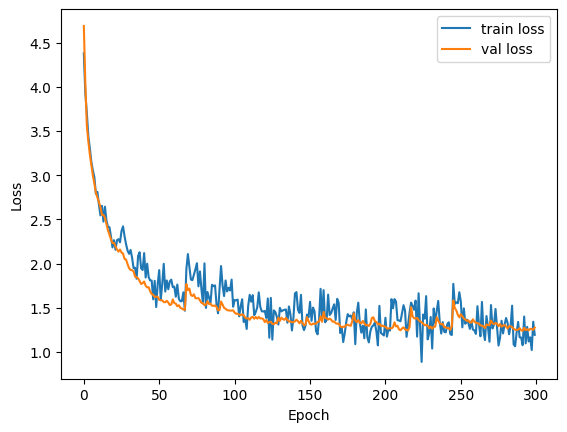

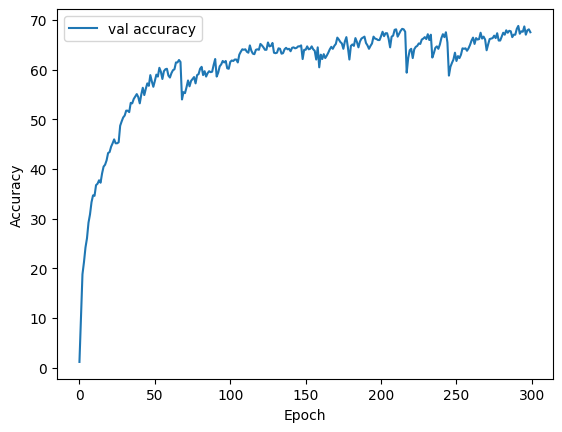

In [7]:
# plot the graphs
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_acc_list, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
import numpy as np

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

params

14170820